## Inference using the trained model

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import math
import json

from IPython.display import Image, display
import random
import jieba

import tensorflow as tf

import config
import inference_wrapper
from inference_utils import caption_generator
from inference_utils import vocabulary

In [8]:
checkpoint_path="../model/show_and_tell_model/model.ckpt-2096"
vocab_file="../data/word_counts.txt"
data_path="../data/"
# dev set
devset_path = os.path.join(data_path, "ai_challenger_caption_validation_20170910")
dev_image_path = os.path.join(devset_path, "caption_validation_images_20170910")
dev_annotation_path = os.path.join(devset_path, "caption_validation_annotations_20170910.json")

In [9]:
# load model
g = tf.Graph()
with g.as_default():
    model = inference_wrapper.InferenceWrapper()
    restore_fn = model.build_graph(checkpoint_path)
g.finalize()

vocab = vocabulary.Vocabulary(vocab_file)
sess = tf.Session(graph=g)
restore_fn(sess)
generator = caption_generator.CaptionGenerator(model, vocab)

INFO:tensorflow:Building model.
INFO:tensorflow:Initializing vocabulary from file: ../data/word_counts.txt
INFO:tensorflow:Created vocabulary with 8562 words
INFO:tensorflow:Loading model from checkpoint: ../model/show_and_tell_model/model.ckpt-2096
INFO:tensorflow:Restoring parameters from ../model/show_and_tell_model/model.ckpt-2096
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-2096


In [4]:
def show_example(example, image_path):
    image_id = example['image_id']
    caption = example['caption']
    im = Image(filename=os.path.join(image_path, image_id)) 
    display(im)
    for c in caption:
        c = c.strip().strip(u"。").replace('\n', '')
        seg_list = jieba.cut(c, cut_all=False)
        print ' '.join(seg_list)
    #return image_id, caption

In [5]:
# read dev data
input = open(dev_annotation_path,'r')
dev_examples = json.load(input)
input.close()
dev_size = len(dev_examples)

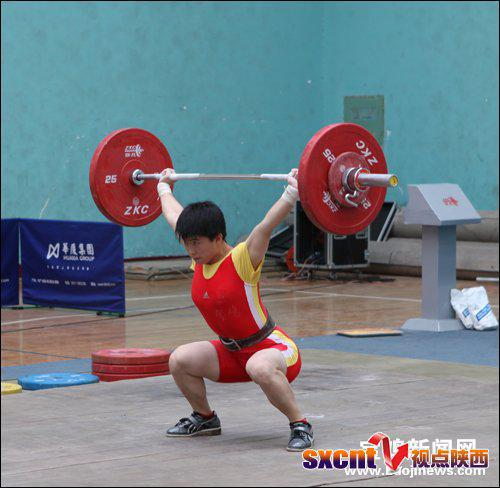

一个 穿着 运动服 的 人 在 运动场 上 举重
运动场 上 有 一个 穿着 运动服 的 人 在 举重
一个半 蹲 着 的 女人 在 宽敞 的 房间 里 双手 向上 举 杠铃
室内 一个 穿着 运动服 的 人 站 在 地板 上 举重
比赛 场上 有 一个 穿着 比赛服 的 人 在 举 杠铃
Captions for image 1f0aed7860b029bdb5d7f855241555e85a892b83.jpg:
  0) 一个 双手 拿 着 球杆 的 男人 站 在 运动场 上 (p=0.000060)
  1) 一个 双手 拿 着 球杆 的 男人 在 运动场 上 打 排球 (p=0.000004)
  2) 一个 双手 拿 着 球杆 的 女人 在 运动场 上 打 排球 (p=0.000003)


In [11]:
# run a random image
index = int(random.random() * dev_size)
show_example(dev_examples[index], dev_image_path)
filename = os.path.join(dev_image_path, dev_examples[index]['image_id'])
f = tf.gfile.GFile(filename, "r")
image=f.read()
captions = generator.beam_search(sess, image)
print("Captions for image %s:" % os.path.basename(filename))
for i, caption in enumerate(captions):
    # Ignore begin and end words.
    sentence = [vocab.id_to_word(w) for w in caption.sentence[1:-1]]
    sentence = " ".join(sentence)
    print("  %d) %s (p=%f)" % (i, sentence, math.exp(caption.logprob)))

